In [1]:
# Reproduction script: main + supplemental figures
# ------------------------------------------------
import warnings
warnings.simplefilter("ignore")

import os
from pathlib import Path
from typing import Final, Literal

import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from shapely.wkb import loads as wkb_loads
from shapely import wkt
import statsmodels.api as sm
from scipy import stats

In [2]:
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
os.chdir(parent_dir)
# ------------------------------------------------
# Paths & IO
# ------------------------------------------------
CWD         = Path.cwd()
DATA_DIR    = Path("burada")
PAPER_DIR   = Path("paper")
FIG_DIR     = Path("figs"); FIG_DIR.mkdir(exist_ok=True)

ZIP_SHP         = DATA_DIR / "zip codes" / "Export_Output_5.shp" # MAPC Zip codes (available online)
MONITOR_CSV     = DATA_DIR / "monitorloc.csv" # PurpleAir monitor locations (from API)    
AQ_DATA_CSV     = Path("aq_data.csv")         # PurpleAir monitor readings (from API)            
EPA_DAILY_CSV   = Path("daily_88101_2023.csv")     # EPA monitor readings (available online)


# Data obtained from the BostonWalks study available at https://web.mit.edu/bostonwalks/
ID_MAP_CSV      = DATA_DIR / "ids.csv"
WEIGHTS_CSV     = PAPER_DIR / "bws_user_weights.csv"
QUALTRICS_CSV   = PAPER_DIR / "qualtrics.csv"
STAYS_CSV       = PAPER_DIR / "storylines_MAPC.csv"


# Precomputed exposure tables
EXPO_RAW_CSV    = Path("1210stays_exposure.csv")
EXPO_ADJ_CSV    = Path("1210stays_exposure2.csv")
EXPO_HOME_CSV   = Path("0123stays_exposure_home.csv")
HOMES_CSV       = Path("homes.csv")

In [3]:
# ------------------------------------------------
# Constants
# ------------------------------------------------
CRS_WGS84       = "EPSG:4326"
CRS_NAD83       = "EPSG:4269"
CRS_M_METERS    = "EPSG:3857"
CRS_MA_METERS   = "EPSG:26986"

DST_SWITCH_TS   = pd.Timestamp("2023-11-05 07:00:00")  # end of DST 2023
INVALID_EXP     = -99
CI_Z            = 1.96

COLOR_SEQ_FULL = [
    "#4292c6","#6baed6","#9ecae1","#c6dbef","#deebf7","#f7fbff",
    "#fff7ec","#fee8c8","#fdd49e","#fdbb84","#fc8d59","#ef6548","#d7301f"
]
COLOR_BLUE      = "#4292c6"
COLOR_BLUE_LT   = "#6baed6"
COLOR_RED       = "#ef6548"

CMAP_RED_SCALE  = mcolors.ListedColormap(
    ["#f7fbff", "#fff7ec", "#fee8c8", "#fdd49e", "#fdbb84",
     "#fc8d59", "#ef6548", "#d7301f"]
)


In [4]:
# ------------------------------------------------
# Helpers
# ------------------------------------------------
def savefig(name: str, fig=None):
    p = FIG_DIR / name
    (fig or plt.gcf()).savefig(p, dpi=300, bbox_inches="tight")
    plt.close(fig or plt.gcf())
    print(f"saved: {p}")

def add_weekend_flag(df: pd.DataFrame, dt_col: str, out_col: str = "is_weekend"):
    df[dt_col]  = pd.to_datetime(df[dt_col], errors="coerce")
    is_we       = df[dt_col].dt.weekday >= 5
    df[out_col] = np.where(is_we, "Yes", "No")
    return df

def recode_demographics(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["income_cat"] = df["income_cat"].replace({1:2, 2:2, 3:3, 4:3, 5:3})
    df["educ_cat"]   = df["educ_cat"]  .replace({1:3, 2:3, 4:4, 5:4})
    df["age_cat"]    = df["age_cat"]   .replace({1:1, 2:1, 3:1, 4:5, 5:5, 6:5, 7:5})
    df["race_cat"]   = df["race_cat"]  .replace({4:4, 5:4, 6:4})
    df["occup"]      = np.where(df["occup"].isin(["Employed","Self-employed"]), "emp", "not emp")
    return df

PURPOSE_REMAP = {
    "assistance":"other","study":"other","medical_visit":"other","wait":"other",
    "shopping":"other","errand":"other","family_friends":"leisure","sport":"leisure"
}

def recategorise_purpose(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    if "purpose" in out.columns:
        out["purpose"] = out["purpose"].replace(PURPOSE_REMAP)
    return out

def gdf_from_wkt(df: pd.DataFrame, geom_col: str = "geometry_real", crs: str = CRS_WGS84) -> gpd.GeoDataFrame:
    out = df.copy()
    out[geom_col] = out[geom_col].apply(wkt.loads)
    return gpd.GeoDataFrame(out, geometry=geom_col, crs=crs)


In [5]:
# ------------------------------------------------
# Load core datasets
# ------------------------------------------------
gdf_zip = gpd.read_file(ZIP_SHP).set_crs(CRS_WGS84, allow_override=True)

df_monitors = pd.read_csv(MONITOR_CSV)
gdf_monitors = gpd.GeoDataFrame(
    df_monitors,
    geometry=gpd.points_from_xy(df_monitors["lon"], df_monitors["lat"]),
    crs=CRS_WGS84,
).pipe(lambda g: gpd.clip(g, gdf_zip))

df_idmap = (pd.read_csv(ID_MAP_CSV).rename(columns={"ids1":"id"})[["id","ids2"]])
df_weights = pd.read_csv(WEIGHTS_CSV).rename(columns={"mt_id":"user_id"})
df_qual    = (pd.read_csv(QUALTRICS_CSV).fillna("nan")
              .merge(df_idmap, how="left")
              .rename(columns={"ids2":"user_id"}))

df_weights = df_weights.merge(df_qual[["user_id","occup","ethnicity"]],
                              how="left", on="user_id")

df_aq      = pd.read_csv(AQ_DATA_CSV)          # expects columns: ids, lags2, pms, ...
df_epa     = pd.read_csv(EPA_DAILY_CSV)


In [6]:
# ------------------------------------------------
# Stays + homes
# ------------------------------------------------
df_stays = (pd.read_csv(STAYS_CSV, parse_dates=["started_at","finished_at"])
              .sort_values("started_at"))

# DST correction
offset = np.where(df_stays["started_at"] < DST_SWITCH_TS, 4, 5)
df_stays["corrected_time_start"] = df_stays["started_at"]  - pd.to_timedelta(offset, unit="h")
df_stays["corrected_time_end"]   = df_stays["finished_at"] - pd.to_timedelta(offset, unit="h")

# users with ≥10-day span
keep_users = (df_stays.groupby("user_id")
              .agg(span=("corrected_time_end", lambda s: (s.max()-s.min()).days))
              .query("span > 10").index)
df_stays = df_stays[df_stays["user_id"].isin(keep_users)]

# filter stays + durations + merge occup
df_stays = (df_stays.loc[df_stays["type"]=="Stay"]
                    .merge(df_qual[["user_id","occup"]], on="user_id", how="left")
                    .query("30 < duration_min < 300")
                    .copy())

# geometry from WKB hex
df_stays["geometry"] = [wkb_loads(bytes.fromhex(x)) for x in df_stays["geometry"]]
gdf_stays = gpd.GeoDataFrame(df_stays, geometry="geometry", crs=CRS_WGS84)

gdf_stays["hour_start"]  = gdf_stays["corrected_time_start"].dt.hour
gdf_stays["hour_end"]    = gdf_stays["corrected_time_end"].dt.hour
gdf_stays["day_start"]   = gdf_stays["corrected_time_start"].dt.day
gdf_stays["month_start"] = gdf_stays["corrected_time_start"].dt.month
gdf_stays["comb_dm"]     = gdf_stays["month_start"].astype(str) + "/" + gdf_stays["day_start"].astype(str)
gdf_stays = add_weekend_flag(gdf_stays, "corrected_time_start", "is_weekend")

# clip to study area
gdf_stays_clip = gpd.clip(gdf_stays, gdf_zip).reset_index(drop=True)

# homes
df_homes = pd.read_csv(HOMES_CSV)
gdf_homes = gpd.GeoDataFrame(df_homes,
    geometry=gpd.points_from_xy(df_homes.lng, df_homes.lat), crs=CRS_NAD83
).to_crs(CRS_WGS84)


In [7]:
# ------------------------------------------------
# Exposure tables
# ------------------------------------------------
df_exp_raw  = pd.read_csv(EXPO_RAW_CSV)      
df_exp_adj  = pd.read_csv(EXPO_ADJ_CSV)      # exposure adjusted/detrended
df_exp_home = pd.read_csv(EXPO_HOME_CSV)    

df_exp_home = df_exp_home.query("exposure != @INVALID_EXP and home != @INVALID_EXP").copy()
df_exp_raw  = df_exp_raw .query("exposure != @INVALID_EXP").copy()
df_exp_adj  = df_exp_adj.query("exposure != @INVALID_EXP").copy()

df_exp_raw  = add_weekend_flag(df_exp_raw,  "corrected_time_start")
df_exp_adj  = add_weekend_flag(df_exp_adj,  "corrected_time_start")
gdf_stays_clip = add_weekend_flag(gdf_stays_clip, "corrected_time_start")

df_exp_adj_orig = df_exp_adj.copy()  # keep an original


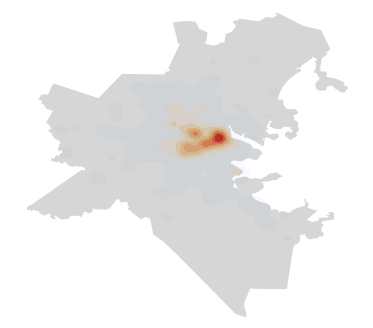

In [8]:
# ------------------------------------------------
# Figure 1a: spatial KDE of stays
# ------------------------------------------------
coords_xy = np.column_stack([gdf_stays_clip.geometry.x, gdf_stays_clip.geometry.y])
fig, ax = plt.subplots(figsize=(6,4), dpi=100)
sns.kdeplot(x=coords_xy[:,0], y=coords_xy[:,1], ax=ax, cmap=CMAP_RED_SCALE,
            fill=True, thresh=0.05, levels=100, cbar=False)
gdf_zip.plot(ax=ax, alpha=0.2, color=".2")
ax.set_aspect("equal"); ax.set_axis_off(); sns.despine()


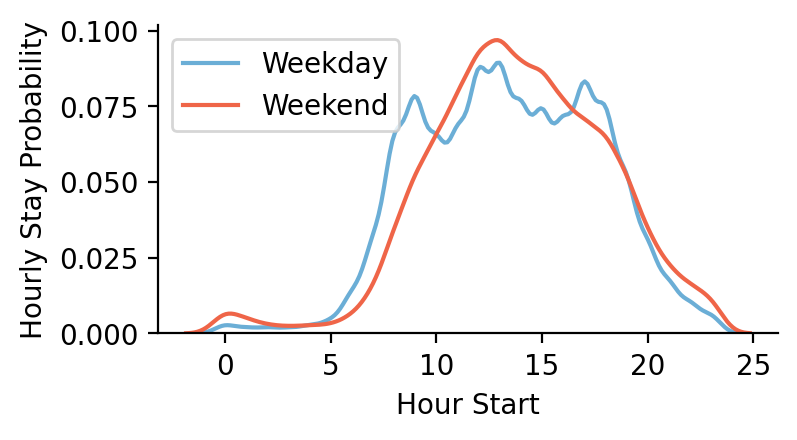

In [9]:
# ------------------------------------------------
# Figure 1b: hour-of-day KDE, weekday vs weekend
# ------------------------------------------------
h_we = gdf_stays_clip.loc[gdf_stays_clip["is_weekend"]=="Yes", "hour_start"]
h_wd = gdf_stays_clip.loc[gdf_stays_clip["is_weekend"]=="No",  "hour_start"]
fig, ax = plt.subplots(figsize=(4,2), dpi=200)
sns.kdeplot(x=h_wd, ax=ax, color=COLOR_BLUE_LT, label="Weekday")
sns.kdeplot(x=h_we, ax=ax, color=COLOR_RED,      label="Weekend")
ax.set(xlabel="Hour Start", ylabel="Hourly Stay Probability")
ax.legend(); sns.despine()


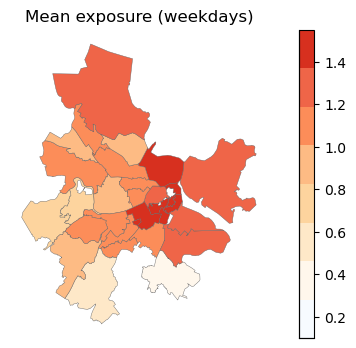

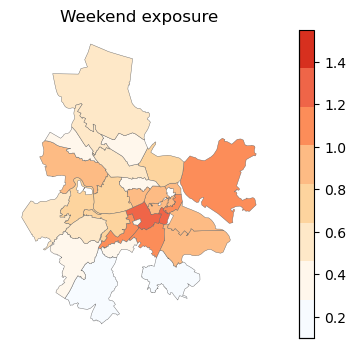

In [10]:
# ------------------------------------------------
# Figure 2a: ZIP maps of exposure (adj) – weekday + weekend
# ------------------------------------------------
def zip_agg(df: pd.DataFrame, weekend: Literal["Yes","No","Both"], top_n: int|None=None) -> gpd.GeoDataFrame:
    use = df if weekend=="Both" else df.query("is_weekend == @weekend")
    gdf = gdf_from_wkt(use, geom_col="geometry_real", crs=CRS_WGS84)
    joined = gpd.sjoin(gdf, gdf_zip[["GEOID20","geometry"]], how="inner", predicate="intersects")
    if top_n:
        keep = joined["GEOID20"].value_counts().nlargest(top_n).index
        joined = joined[joined["GEOID20"].isin(keep)]
    expo = (joined.groupby("GEOID20", as_index=False)["exposure"].mean()
                  .merge(gdf_zip[["GEOID20","geometry"]], on="GEOID20"))
    return gpd.GeoDataFrame(expo, geometry="geometry", crs=gdf_zip.crs)

df_exp_clean = recategorise_purpose(df_exp_adj_orig)
gdf_zip_weekday = zip_agg(df_exp_clean, weekend="No", top_n=30)
gdf_zip_weekend = zip_agg(df_exp_clean, weekend="Yes")
gdf_zip_all     = zip_agg(df_exp_clean, weekend="Both", top_n=30)

def plot_zip_map(gdf_in: gpd.GeoDataFrame, title: str, out: str, vmin=None, vmax=None):
    fig, ax = plt.subplots(figsize=(8,4), dpi=100)
    gdf_in.plot(column="exposure", cmap=CMAP_RED_SCALE, ax=ax, legend=True,
                edgecolor=".4", linewidth=0.3, vmin=vmin, vmax=vmax)
    ax.set_axis_off(); ax.set_title(title); sns.despine()

plot_zip_map(gdf_zip_weekday,     "Mean exposure (weekdays)", "fig2a_all_zip.png", vmin=0.10, vmax=1.55)
plot_zip_map(gdf_zip_weekend.merge(gdf_zip_all[["GEOID20"]]),
             "Weekend exposure", "fig2a_weekend_zip.png", vmin=0.10, vmax=1.55)

In [ ]:
# ---------------------------------------------------------------------
# Spatial autocorrelation (Moran’s I) for weekend map
# ---------------------------------------------------------------------
w = libpysal.weights.Queen.from_dataframe(zip_weekend)
w.transform = "R"
moran = esda.moran.Moran(zip_weekend["exposure"].values, w)

print(f"Moran's I = {moran.I:.3f} (p = {moran.p_sim:.3f}, "f"z = {moran.z_sim:.2f}, permutations = {moran.permutations})")


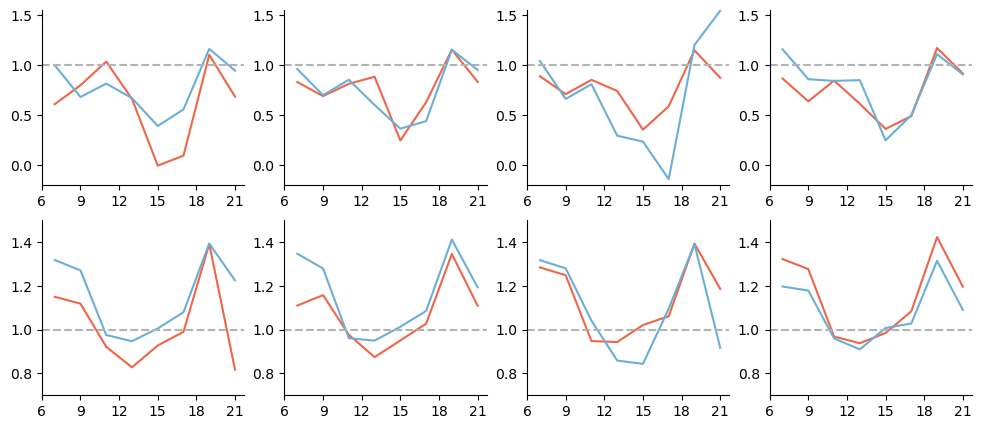

In [11]:
# ------------------------------------------------
# Figure 2b: exposure vs. hour, by demographics (weekday/weekend rows)
# ------------------------------------------------
df_demo = (df_exp_adj_orig
           .merge(df_weights[["user_id","age_cat","income_cat","race_cat","educ_cat","acs_weight","ethnicity_y"]],
                  on="user_id", how="left")
           .pipe(recode_demographics)
           .query("5 < hour_start < 22")
           .assign(hour_pair=lambda d: d["hour_start"].apply(lambda h: h if h % 2 else h + 1)))

df_demo_we = df_demo[df_demo["is_weekend"]=="Yes"]
df_demo_wd = df_demo[df_demo["is_weekend"]=="No"]

CAT_VARS = ["educ_cat","income_cat","age_cat","occup"]
XTICKS   = [6, 9, 12, 15, 18, 21]
fig, axes = plt.subplots(nrows=2, ncols=len(CAT_VARS), figsize=(3*len(CAT_VARS),5), dpi=100)

def _twoline(ax, pivot):
    ax.plot(pivot.columns, pivot.iloc[0], color=COLOR_RED)       # weekend line
    ax.plot(pivot.columns, pivot.iloc[1], color=COLOR_BLUE_LT)   # weekday line
    ax.axhline(1, color=".7", ls="--"); sns.despine(ax=ax)

for j, cat in enumerate(CAT_VARS):
    p_we = (df_demo_we.groupby([cat,"hour_pair"])["exposure"].mean().unstack("hour_pair").sort_index())
    p_wd = (df_demo_wd.groupby([cat,"hour_pair"])["exposure"].mean().unstack("hour_pair").sort_index())
    axes[0,j]; _twoline(axes[0,j], p_we); axes[0,j].set(xticks=XTICKS, ylim=(-0.2,1.55))
    axes[1,j]; _twoline(axes[1,j], p_wd); axes[1,j].set(xticks=XTICKS, ylim=(0.7,1.5))


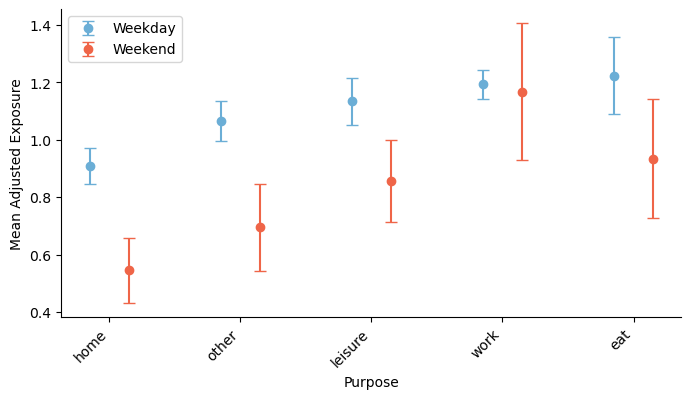

In [12]:
# ------------------------------------------------
# Figure 2c: purpose means ± 95% CI, weekday vs weekend
# ------------------------------------------------
def summarise_ci_by_purpose(df: pd.DataFrame, label: str) -> pd.DataFrame:
    sdf = (df[df["purpose"]!="unknown"].groupby("id", as_index=False)
           .mean(numeric_only=True).merge(df[["id","purpose"]].drop_duplicates("id")))
    g = sdf.groupby("purpose")["exposure"]
    out = pd.DataFrame({
        f"mean_{label}": g.mean(),
        f"std_{label}":  g.std(ddof=1),
        f"count_{label}":g.count()
    })
    out[f"ci_{label}"] = CI_Z * out[f"std_{label}"] / np.sqrt(out[f"count_{label}"])
    return out.drop(columns=f"std_{label}")

df_purp = recategorise_purpose(df_exp_adj_orig)
wd = df_purp[df_purp["is_weekend"]=="No"].copy()
we = df_purp[df_purp["is_weekend"]=="Yes"].copy()

stats_wd = summarise_ci_by_purpose(wd, "wd")
stats_we = summarise_ci_by_purpose(we, "we")
combined = stats_wd.join(stats_we, how="outer").fillna(0).sort_values("mean_wd")

purposes = combined.index.tolist()
x = np.arange(len(purposes)); off = 0.15
fig, ax = plt.subplots(figsize=(8,4), dpi=100)
ax.errorbar(x-off, combined["mean_wd"], yerr=combined["ci_wd"], fmt="o", color=COLOR_BLUE_LT, ecolor=COLOR_BLUE_LT, label="Weekday", capsize=4)
ax.errorbar(x+off, combined["mean_we"], yerr=combined["ci_we"], fmt="o", color=COLOR_RED,     ecolor=COLOR_RED,     label="Weekend", capsize=4)
ax.set(xlabel="Purpose", ylabel="Mean Adjusted Exposure", xticks=x, xticklabels=purposes)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right"); ax.legend(); sns.despine()


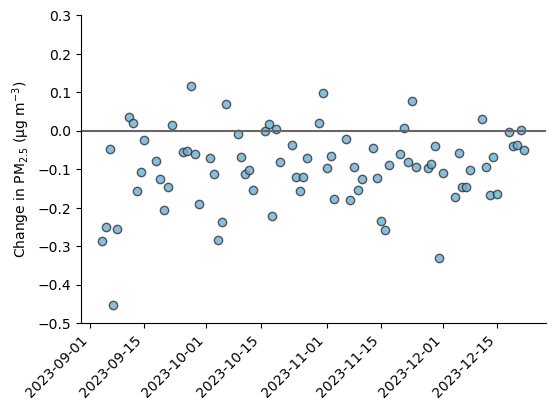

In [13]:
# ------------------------------------------------
# Figure 3b: daily Δ (home - away) 
# ------------------------------------------------
sh = (df_exp_home.copy()
      .query("home > 0 and exposure > 0 and purpose != 'home'"))
sh["delta_abs"] = sh["home"] - sh["exposure"]

counts = sh["comb_dm"].value_counts()
sh_day = (sh[sh["comb_dm"].isin(counts[counts > 300].index)]
          .groupby("comb_dm", as_index=False)["delta_abs"].mean()
          .rename(columns={"delta_abs":"delta_mean"}))
sh_day["date"] = pd.to_datetime(sh_day["comb_dm"] + "/2023", format="%m/%d/%Y")
sh_day = sh_day.query("date > '2023-09-01'").sort_values("date")

fig, ax = plt.subplots(figsize=(6,4), dpi=100)
ax.scatter(sh_day["date"], sh_day["delta_mean"], color=COLOR_BLUE_LT, alpha=0.8, edgecolor=".2")
ax.axhline(0, color=".4"); ax.set(ylabel="Change in PM$_{2.5}$ (µg m$^{-3}$)", ylim=(-0.5,0.3))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right"); sns.despine()


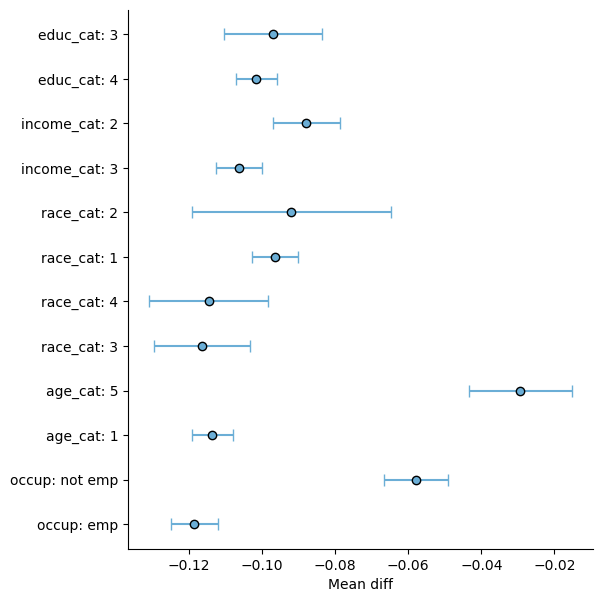

In [14]:
# ------------------------------------------------
# Figure 3c: Δ by sociodemographic group (mean ± CI)
# ------------------------------------------------
CAT_COLS = ["educ_cat","income_cat","race_cat","age_cat","occup"]
sh2 = (df_exp_home.copy()
       .merge(df_weights[["user_id", *CAT_COLS]], how="left")
       .query("purpose != 'home' and started_at > '2023-09-01'"))
for col in ["income_cat","educ_cat","age_cat","race_cat"]:
    sh2[col] = sh2[col].replace({
        "income_cat":{1:2,2:2,3:3,4:3,5:3},
        "educ_cat":  {1:3,2:3,4:4,5:4},
        "age_cat":   {1:1,2:1,3:1,4:5,5:5,6:5,7:5},
        "race_cat":  {4:4,5:4,6:4},
    }.get(col, {}))
sh2["occup"] = np.where(sh2["occup"].isin(["Employed","Self-employed"]), "emp", "not emp")
sh2["diff"]  = sh2["home"] - sh2["exposure"]

rows = []
for cat in CAT_COLS:
    g = sh2.groupby(cat)["diff"].agg(mean="mean", sem="sem")
    g["ci"] = CI_Z * g["sem"]
    for grp, r in g.sort_values("mean", ascending=False).iterrows():
        rows.append({"cat_var":cat, "group":grp, "mean":r["mean"], "ci":r["ci"]})
df_sum = pd.DataFrame(rows)

y = np.arange(len(df_sum))
fig, ax = plt.subplots(figsize=(6,7), dpi=100)
ax.errorbar(df_sum["mean"], y, xerr=df_sum["ci"], fmt="o", color=COLOR_BLUE_LT, markeredgecolor="black", capsize=4)
ax.set(yticks=y, yticklabels=df_sum.apply(lambda r: f"{r.cat_var}: {r.group}", axis=1), xlabel="Mean diff")
ax.invert_yaxis(); sns.despine()


In [15]:
# ------------------------------------------------
# Table 1: WLS (weekday only)
# ------------------------------------------------
df_reg = (df_demo[df_demo["is_weekend"]=="No"]
          [["race_cat","educ_cat","income_cat","age_cat","occup","ethnicity_y","exposure","acs_weight"]].copy())
for v in ["race_cat","educ_cat","income_cat","age_cat","occup","ethnicity_y"]:
    df_reg[v] = df_reg[v].astype("category")

df_reg = pd.get_dummies(df_reg, drop_first=True)

bool_cols = df_reg.select_dtypes(include=["bool"]).columns
if len(bool_cols):
    df_reg[bool_cols] = df_reg[bool_cols].astype(int)

X = sm.add_constant(df_reg.drop(columns=["acs_weight", "exposure"]))
y = df_reg["exposure"].to_numpy(); w = df_reg["acs_weight"].to_numpy()
res = sm.WLS(y, X, weights=w).fit()

print(res.summary())


                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            WLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     33.25
Date:                Mon, 11 Aug 2025   Prob (F-statistic):           7.71e-53
Time:                        09:16:40   Log-Likelihood:            -3.5254e+05
No. Observations:              141870   AIC:                         7.051e+05
Df Residuals:                  141861   BIC:                         7.052e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

<Axes: ylabel='y_var-y_category'>

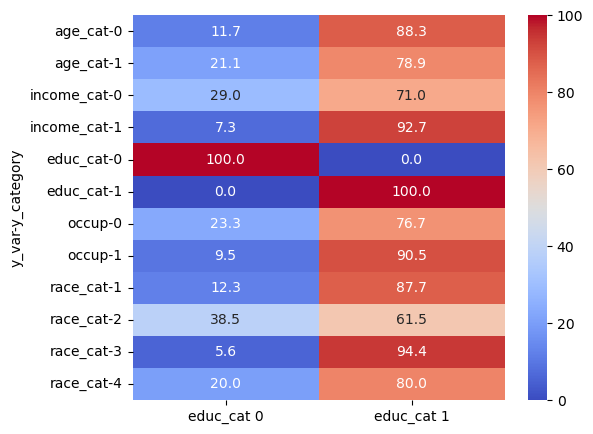

In [16]:
# ------------------------------------------------
# Figure S6: heatmap (education cross-distribution example)
# ------------------------------------------------
wey_bin = df_weights.copy()
wey_bin["income_cat"] = wey_bin["income_cat"].replace({1:0,2:0,3:1,4:1,5:1})
wey_bin["educ_cat"]   = wey_bin["educ_cat"]  .replace({1:0,2:0,3:0,4:1,5:1})
wey_bin["age_cat"]    = wey_bin["age_cat"]   .replace({1:0,2:0,3:0,4:1,5:1,6:1,7:1})
wey_bin["race_cat"]   = wey_bin["race_cat"]  .replace({4:4,5:4,6:4})
wey_bin["occup"]      = np.where(wey_bin["occup"].isin(["Employed","Self-employed"]), 1, 0)

df_demo_bin = wey_bin.copy()
x_vars = ["age_cat","income_cat","educ_cat"]
y_vars = ["age_cat","income_cat","educ_cat","occup","race_cat"]
rows = []
for yv in y_vars:
    for grp, sub in df_demo_bin.groupby(yv):
        row = {"y_var":yv, "y_category":grp}
        for xv in x_vars:
            poss = sorted(df_demo_bin[xv].dropna().unique())
            pct = (sub[xv].value_counts(normalize=True) * 100)
            for v in poss:
                row[f"{xv} {v}"] = pct.get(v, 0.0)
        rows.append(row)
df_heat = pd.DataFrame(rows).set_index(["y_var","y_category"])

edu_cols = [c for c in df_heat.columns if c.startswith("educ_cat ")]
fig, ax = plt.subplots(figsize=(6,5), dpi=100)
sns.heatmap(df_heat[edu_cols], annot=True, cmap="coolwarm", fmt=".1f", vmin=0, vmax=100)


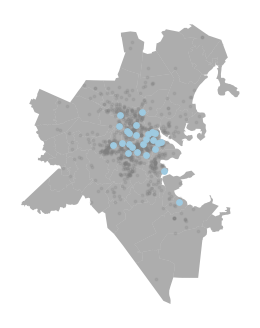

In [17]:
# ------------------------------------------------
# Figure S4: DBSCAN clusters (weekday non-home centroids)
# ------------------------------------------------
from sklearn.cluster import DBSCAN
EPZ_M = 225
MIN_S = 200

st_wd_nh = gdf_stays_clip[(gdf_stays_clip["is_weekend"]=="No") & (gdf_stays_clip["purpose"]!="home")].copy()
gdf_st_m = gpd.GeoDataFrame(st_wd_nh[["geometry"]], geometry="geometry", crs=gdf_stays_clip.crs).to_crs(CRS_M_METERS)
coords = np.column_stack([gdf_st_m.geometry.x, gdf_st_m.geometry.y])
labels = DBSCAN(eps=EPZ_M, min_samples=MIN_S).fit_predict(coords) if len(coords) else np.array([])
gdf_st_m = gdf_st_m.assign(cluster=labels)
gdf_st_m = gdf_st_m[gdf_st_m["cluster"]!=-1]
fig, ax = plt.subplots(figsize=(6,4), dpi=100)
gdf_zip.plot(ax=ax, alpha=0.4, color=".2")
gdf_homes.plot(ax=ax, markersize=3, alpha=0.2, color=".5")
if not gdf_st_m.empty:
    centroids = gdf_st_m.dissolve(by="cluster").centroid.to_frame("geometry")
    gpd.GeoDataFrame(centroids, geometry="geometry", crs=CRS_M_METERS).to_crs(CRS_WGS84).plot(
        ax=ax, color=COLOR_SEQ_FULL[2], markersize=15, label="Cluster centroids"
    )
ax.set_axis_off(); sns.despine()


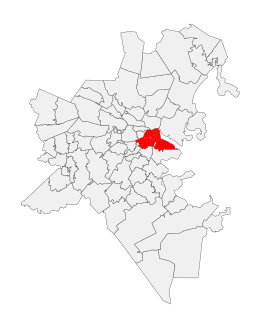

In [18]:
# ------------------------------------------------
# Figure S5a: highlight downtown ZIPs
# ------------------------------------------------
downtown = ['02210','02114','02113','02203','02109','02110','02108','02116','02111','02199']
fig, ax = plt.subplots(figsize=(6,4), dpi=100)
gdf_zip.plot(ax=ax, edgecolor=".4", linewidth=0.3, color=".94", alpha=0.99)
gdf_zip[gdf_zip["ZCTA5CE20"].isin(downtown)].plot(ax=ax, color="red")
ax.set_axis_off(); sns.despine()


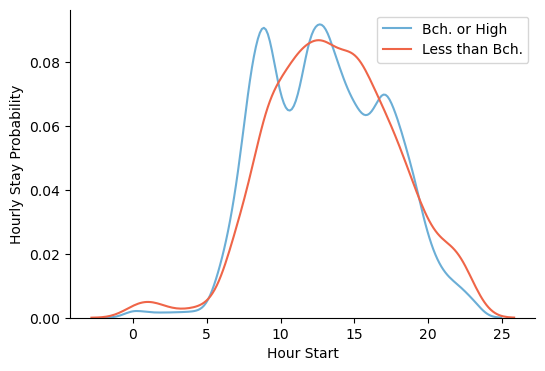

In [19]:
# ------------------------------------------------
# Figure S5b/d: hour KDE in selected zips by education (weekday)
# ------------------------------------------------
gdf_st_demo = gdf_stays_clip.merge(df_weights[["user_id","educ_cat"]], on="user_id", how="left")
gdf_st_demo["educ_cat"] = gdf_st_demo["educ_cat"].replace({1:3,2:3,4:4,5:4})
gdf_st_demo["occup"]    = np.where(gdf_st_demo["occup"].isin(["Employed","Self-employed"]),"emp","not emp")
target = gdf_zip[gdf_zip["ZCTA5CE20"].isin(downtown)]
gdf_in = gpd.clip(gdf_st_demo, target)
wkday  = gdf_in[gdf_in["is_weekend"]=="No"]
fig, ax = plt.subplots(figsize=(6,4), dpi=100)
sns.kdeplot(x=wkday.loc[wkday["educ_cat"]==4, "hour_start"], ax=ax, color=COLOR_BLUE_LT, label="Bch. or High")
sns.kdeplot(x=wkday.loc[wkday["educ_cat"]==3, "hour_start"], ax=ax, color=COLOR_RED,     label="Less than Bch.")
ax.set_xlabel("Hour Start"); ax.set_ylabel("Hourly Stay Probability"); ax.legend(); sns.despine()


In [ ]:
# ------------------------------------------------
# Figure S2a: three ZIPs, weekend vs weekday hour KDEs
# ------------------------------------------------
top3 = gdf_zip_all[gdf_zip_all["GEOID20"].isin(["02139","02215","02116"])][["geometry","GEOID20"]]
st_we = gdf_stays_clip[(gdf_stays_clip["is_weekend"]=="Yes") & (gdf_stays_clip["hour_start"].between(5,21))]
st_wd = gdf_stays_clip[(gdf_stays_clip["is_weekend"]=="No")  & (gdf_stays_clip["hour_start"].between(5,21))]
fig, axes = plt.subplots(1, 3, figsize=(12,4), dpi=100)
for i in range(3):
    ax = axes[i]
    sub = top3.iloc[i:i+1]
    we_hours = gpd.sjoin(st_we, sub, how="inner", predicate="intersects")["hour_start"]
    wd_hours = gpd.sjoin(st_wd, sub, how="inner", predicate="intersects")["hour_start"]
    z = top3.iloc[i].GEOID20
    sns.kdeplot(we_hours, ax=ax, label="Weekend", color=COLOR_BLUE_LT)
    sns.kdeplot(wd_hours, ax=ax, label="Weekday", color=COLOR_RED)
    ax.set_title(f"Zip {z}"); ax.set_xlabel("Hour Start"); ax.set_ylabel("Density")
    ax.set_xticks([5,10,15,20]); ax.legend(fontsize=8); sns.despine(ax=ax)


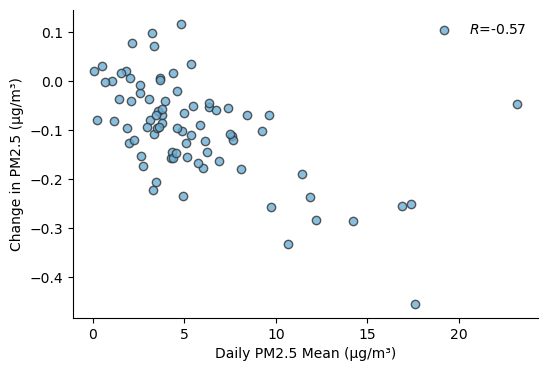

In [21]:
# ------------------------------------------------
# Figure S8: Δ vs daily PM2.5 (correlation)
# ------------------------------------------------
df_aq2 = df_aq.copy()
df_aq2["lags2"] = pd.to_datetime(df_aq2["lags2"]).dt.normalize()
sh3 = (df_exp_home.query("home>0 and exposure>0 and purpose!='home'").copy())
sh3["delta_abs"] = sh3["home"] - sh3["exposure"]
counts = sh3["comb_dm"].value_counts()
sh3 = (sh3[sh3["comb_dm"].isin(counts[counts>300].index)]
       .groupby("comb_dm", as_index=False)["delta_abs"].mean())
sh3["comb_dm_datetime"] = pd.to_datetime(sh3["comb_dm"] + "/2023", format="%m/%d/%Y")
sh3 = sh3.sort_values("comb_dm_datetime")
sh3 = sh3[sh3["comb_dm_datetime"] > pd.to_datetime("2023-09-01")]

df_aq2 = df_aq2[df_aq2["lags2"].isin(sh3["comb_dm_datetime"])]
df_aq_daily = df_aq2.groupby("lags2", as_index=False)["pms"].mean()
m = sh3.merge(df_aq_daily, left_on="comb_dm_datetime", right_on="lags2")
r = stats.pearsonr(m["pms"], m["delta_abs"])[0]

fig, ax = plt.subplots(figsize=(6,4), dpi=100)
ax.scatter(m["pms"], m["delta_abs"], color=COLOR_BLUE_LT, alpha=0.8, edgecolor=".2", label=f"$R$={r:.2f}")
ax.legend(frameon=False); ax.set(xlabel="Daily PM2.5 Mean (µg/m³)", ylabel="Change in PM2.5 (µg/m³)"); sns.despine()


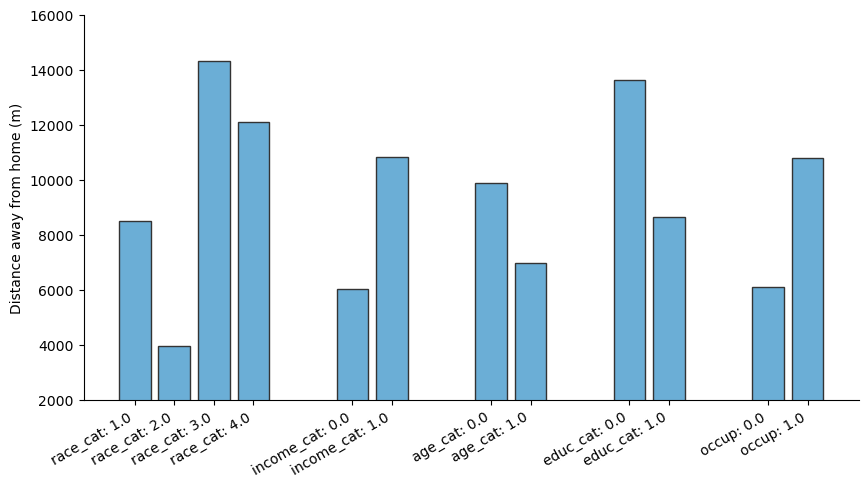

In [22]:

# ------------------------------------------------
# Figure S9: distance from home by group (mean bars)
# ------------------------------------------------
st2 = gpd.GeoDataFrame(gdf_stays[["geometry","user_id"]], geometry="geometry", crs=CRS_WGS84).to_crs(CRS_MA_METERS)
hm2 = gdf_homes.to_crs(CRS_MA_METERS).rename(columns={"uid":"user_id"})
merged = st2.merge(hm2[["user_id","geometry"]], on="user_id", suffixes=("_stay","_home"))
merged["distance_m"] = merged["geometry_stay"].distance(merged["geometry_home"])
cats = ["race_cat","income_cat","age_cat","educ_cat","occup"]

x_pos, heights, tick_pos, tick_lbl = [], [], [], []
x = 0.0; GAP = 1.5
for c in cats:
    s = merged.merge(wey_bin[["user_id",c]], on="user_id", how="left").groupby(c)["distance_m"].mean()
    order = [g for g in sorted(s.index)]; s = s.reindex(order)
    n = len(s); xs = np.arange(x, x+n)
    x_pos.extend(xs.tolist()); heights.extend(s.fillna(0).tolist())
    tick_pos.extend(xs.tolist()); tick_lbl.extend([f"{c}: {g}" for g in s.index])
    x += n + GAP
fig, ax = plt.subplots(figsize=(10,5), dpi=100)
ax.bar(x_pos, heights, color=COLOR_BLUE_LT, edgecolor=".2")
ax.set_xticks(tick_pos); ax.set_xticklabels(tick_lbl, rotation=30, ha="right")
ax.set_ylabel("Distance away from home (m)"); ax.set_ylim(2000,16000); sns.despine()


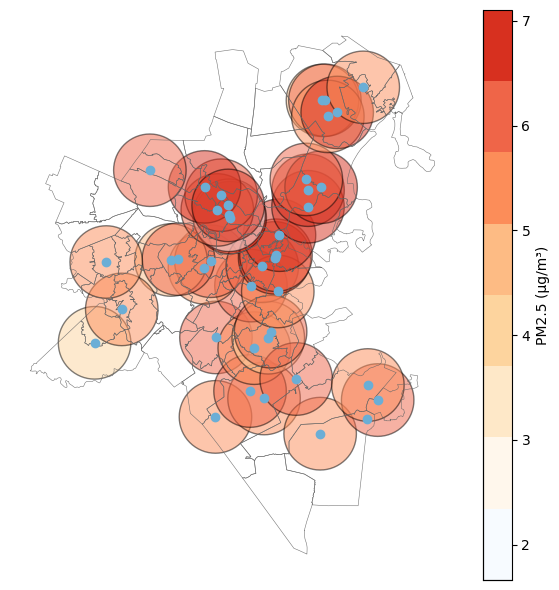

In [23]:
# ------------------------------------------------
# Figure S1a: buffered sensors colored by mean PM 
# ------------------------------------------------

CRS_METERS  = "EPSG:3857"    
BUFFER_M    = 4000
CMAP_COLORS = ['#f7fbff','#fff7ec','#fee8c8','#fdd49e','#fdbb84','#fc8d59','#ef6548','#d7301f']
cmap_fig3   = mcolors.ListedColormap(CMAP_COLORS)

df2tt = df_aq.copy()
df2tt['lags2'] = pd.to_datetime(df2tt['lags2']).dt.normalize()
df2tt = df2tt[df2tt['lags2'].isin(sh3['comb_dm_datetime'])]

df2tt_gp = (
    df2tt.groupby('ids', as_index=False)
         .mean(numeric_only=True)[['ids', 'pms']]
)

monitor_mg = gdf_monitors[gdf_monitors['id'].isin(df2tt_gp['ids'])].merge(
    df2tt_gp, left_on='id', right_on='ids', how='inner'
)
monitor_mg = monitor_mg[monitor_mg['ids'] != 94799][['geometry', 'ids', 'pms']].copy()

monitor_mg = monitor_mg.set_crs(CRS_WGS84, allow_override=True).to_crs(CRS_METERS)

monitor_mg['geometry'] = monitor_mg.buffer(BUFFER_M)
monitor_mg = monitor_mg.to_crs(CRS_WGS84)


fig, ax = plt.subplots(figsize=(6, 6), dpi=100)

gdf_zip.plot(ax=ax, alpha=0.9, edgecolor=".4", color="None", linewidth=0.4, zorder=4)

monitor_mg.plot(
    column="pms",
    cmap=cmap_fig3,
    legend=True,
    ax=ax,
    edgecolor="black",
    alpha=0.5,
    legend_kwds={'label': "PM2.5 (µg/m³)"},
    zorder=3,
)

gdf_monitors[gdf_monitors['id'].isin(df2tt_gp['ids'])].plot(ax=ax, color=COLOR_BLUE_LT, zorder=5)

sns.despine()
ax.set_axis_off()
plt.tight_layout()
plt.show()



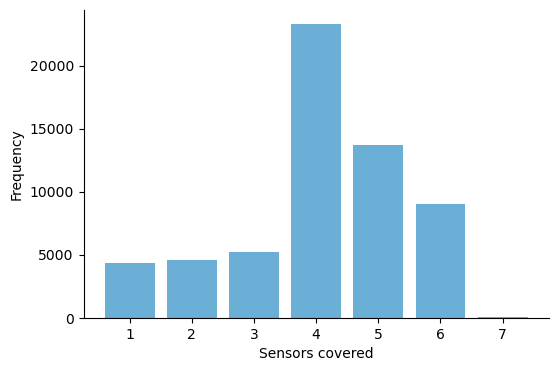

In [24]:
# ------------------------------------------------
# Figure S1b: coverage—# sensors per stay (bar)
# ------------------------------------------------
thres_ids = df_aq["ids"].unique()
gdf_sens = gdf_monitors[gdf_monitors["id"].isin(thres_ids)]
gdf_sens_buf = (gdf_sens.to_crs(CRS_M_METERS).buffer(4000).to_crs(CRS_WGS84))
gdf_sens_buf = gpd.GeoDataFrame({"id":gdf_sens["id"].values, "geometry":gdf_sens_buf}, crs=CRS_WGS84)
sj = gpd.sjoin(gdf_sens_buf, gdf_stays_clip, how="inner", predicate="intersects")
counts_per_stay = sj["index_right"].value_counts()
freq = counts_per_stay.value_counts().sort_index()
coverage_df = freq.rename_axis("sensors_covered").reset_index(name="frequency")

fig, ax = plt.subplots(figsize=(6,4), dpi=100)
ax.bar(coverage_df["sensors_covered"].astype(str), coverage_df["frequency"], color=COLOR_BLUE_LT)
ax.set_xlabel("Sensors covered"); ax.set_ylabel("Frequency"); sns.despine()


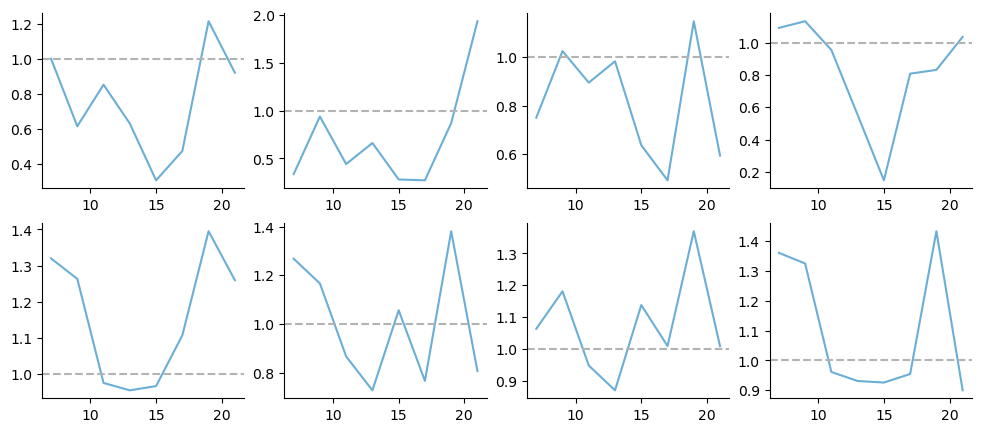

In [25]:
# ------------------------------------------------
# Figure S3: exposure vs hour by race (weekday/weekend grids)
# ------------------------------------------------
def mean_by_hourpair(df):
    return (df.groupby(["race_cat","hour_pair"])["exposure"].mean().unstack("hour_pair"))
races = sorted(df_demo["race_cat"].dropna().unique())
p_we = mean_by_hourpair(df_demo[df_demo["is_weekend"]=="Yes"]).reindex(races)
p_wd = mean_by_hourpair(df_demo[df_demo["is_weekend"]=="No"]).reindex(races)
fig, axes = plt.subplots(2, len(races), figsize=(3*len(races),5), dpi=100)
if len(races)==1: axes = axes.reshape(2,1)
for i, r in enumerate(races):
    ax = axes[0,i]; s = p_we.loc[r].dropna(); ax.plot(s.index, s.values, color=COLOR_BLUE_LT); ax.axhline(1, color=".7", ls="--"); sns.despine(ax=ax)
    ax = axes[1,i]; s = p_wd.loc[r].dropna(); ax.plot(s.index, s.values, color=COLOR_BLUE_LT); ax.axhline(1, color=".7", ls="--"); sns.despine(ax=ax)


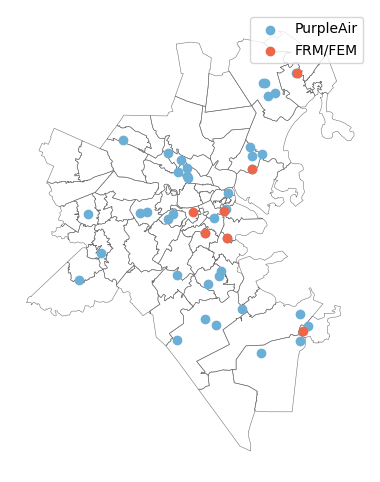

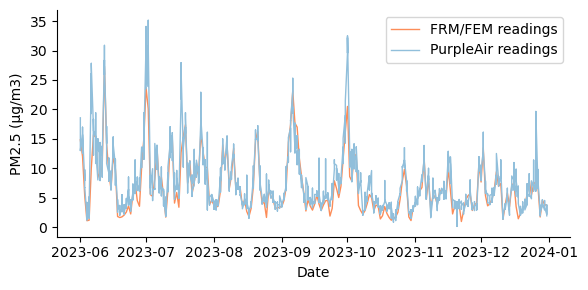

In [26]:
# ------------------------------------------------
# Figure S10: sensor locations (PurpleAir vs FRM/FEM) + daily timeseries
# ------------------------------------------------
# FRM/FEM monitor points (Massachusetts subset) overlay
hourly_pm=df_epa[(df_epa['State Name']=='Massachusetts')]
hourly_pm['uid'] = hourly_pm['State Code'].astype(str) + hourly_pm['County Code'].astype(str) + hourly_pm['Site Num'].astype(str)+ hourly_pm['Latitude'].astype(str)
hourly_pm =hourly_pm.drop_duplicates('uid')
monitor_locs_gdf = gpd.GeoDataFrame(
    hourly_pm, geometry=gpd.points_from_xy(hourly_pm.Longitude, hourly_pm.Latitude),crs = CRS_WGS84)
monitor_locs_gdf = monitor_locs_gdf.clip(gdf_zip)

hourly_pm=df_epa[(df_epa['State Name']=='Massachusetts')]
hourly_pm['uid'] = hourly_pm['State Code'].astype(str) + hourly_pm['County Code'].astype(str) + hourly_pm['Site Num'].astype(str)+ hourly_pm['Latitude'].astype(str)
hourly_pm = hourly_pm[hourly_pm['uid'].isin(monitor_locs_gdf['uid'])]
hourly_pm = hourly_pm[['Date Local','Arithmetic Mean']]


hourly_pm['date'] = pd.to_datetime(hourly_pm['Date Local']).dt.date
hourly_pm = hourly_pm.rename(columns={'Arithmetic Mean': 'mean_pm'})

hourly_pm = hourly_pm[hourly_pm['Date Local']>='2023-06-01']

aq_data = df_aq[df_aq['pms']>0]
aq_data['date'] = pd.to_datetime(aq_data['lags2']).dt.date

cutoff = pd.to_datetime('2023-06-01').date()
aq_data = aq_data[aq_data['date']>=cutoff]
hourly_pm = hourly_pm.sort_values('date')
aq_data = aq_data.sort_values('date')

df2t_individual = (
    aq_data
    .groupby(['ids', 'date'])['pms']
    .mean()
    .reset_index()
)

df2t_daily_avg = (
    aq_data
    .groupby('date')['pms']
    .mean()
    .reset_index()
)

fig, ax = plt.subplots(figsize=(6,6), dpi=100)
gdf_zip.plot(ax=ax, alpha=0.9, edgecolor=".4", color="None", linewidth=0.4, zorder=2)
gdf_monitors = gdf_monitors[gdf_monitors['id'].isin(df_aq['ids'].unique())]
gdf_monitors.plot(ax=ax, color=COLOR_BLUE_LT, label="PurpleAir", zorder=3)
monitor_locs_gdf.plot(ax=ax, color=COLOR_RED, label="FRM/FEM", zorder=4)
ax.legend(); ax.set_axis_off(); sns.despine()

fig, ax = plt.subplots(figsize=(6, 3), dpi=100)

plt.plot(
    df2t_daily_avg['date'],
    df2t_daily_avg['pms'],
    linewidth=1,color = '#fc8d59' ,
    label='FRM/FEM readings'
)
plt.plot(
    hourly_pm['date'],
    hourly_pm['mean_pm'],
    linewidth=1,color = '#91bfdb',
    label='PurpleAir readings'
)

plt.xlabel('Date')
plt.ylabel('PM2.5 (µg/m3)')
plt.legend()
sns.despine()
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import r2_score

r2 = r2_score(findr2['pms'], findr2['mean_pm'])
rmse= np.sqrt(mean_squared_error(findr2['pms'],findr2['mean_pm']))
plt.scatter(
    hourly_pm['date'],
    hourly_pm['mean_pm'],alpha=0,label=f'$R^2$ = {r2:.2f}'
)
plt.scatter(
    hourly_pm['date'],
    hourly_pm['mean_pm'],alpha=0,label=f'RMSE = {rmse:.2f}'
)


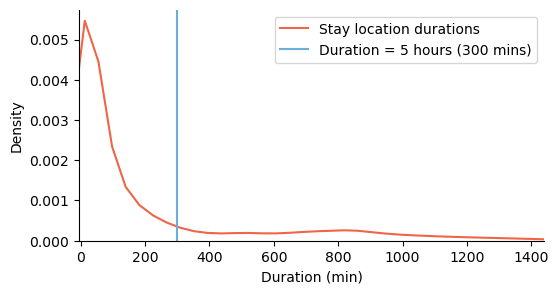

In [27]:
# ------------------------------------------------
# Figure S12: stay duration KDE (+ 5-hour reference)
# ------------------------------------------------
df_stays2 = (pd.read_csv(STAYS_CSV, parse_dates=["started_at","finished_at"])
               .sort_values("started_at"))
ofs = np.where(df_stays2["started_at"] < DST_SWITCH_TS, 4, 5)
df_stays2["corrected_time_end"] = df_stays2["finished_at"] - pd.to_timedelta(ofs, unit="h")
st_plt = df_stays2[df_stays2["type"]=="Stay"]
fig, ax = plt.subplots(figsize=(6,3), dpi=100)
sns.kdeplot(st_plt["duration_min"], color=COLOR_RED, label="Stay location durations", ax=ax)
plt.axvline(300, color=COLOR_BLUE_LT, label="Duration = 5 hours (300 mins)")
ax.set_xlim(-5,1440); ax.set_xlabel("Duration (min)"); ax.legend(); sns.despine()
